## 1. Data Visualization 
### full dataset

emotion
neutral      6868
happiness    5696
surprise      368
sadness       268
anger         252
disgust       208
Name: count, dtype: int64


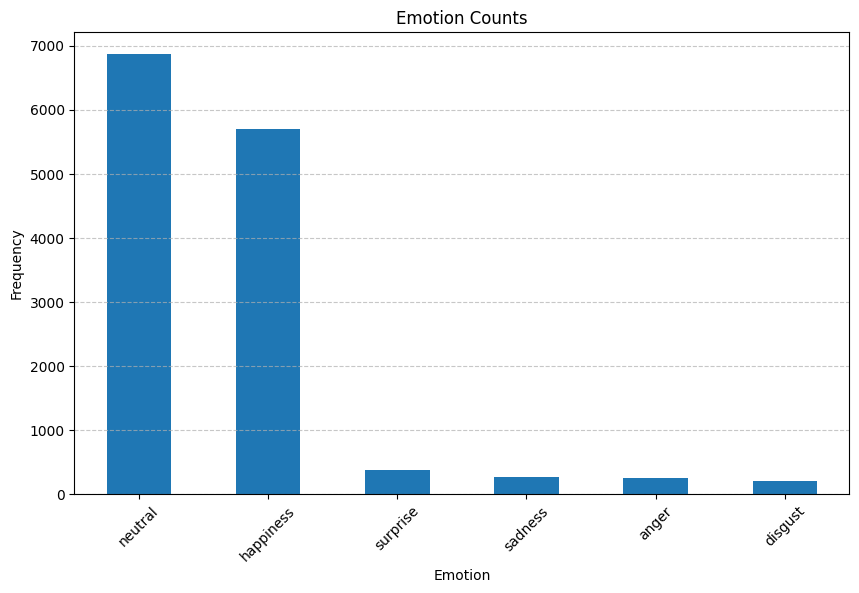

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


df = pd.read_csv('modified/legend_modified.csv')

emotion_counts = df['emotion'].value_counts()

print(emotion_counts)

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### sample_2000

emotion
neutral      452
happiness    452
surprise     368
sadness      268
anger        252
disgust      208
Name: count, dtype: int64


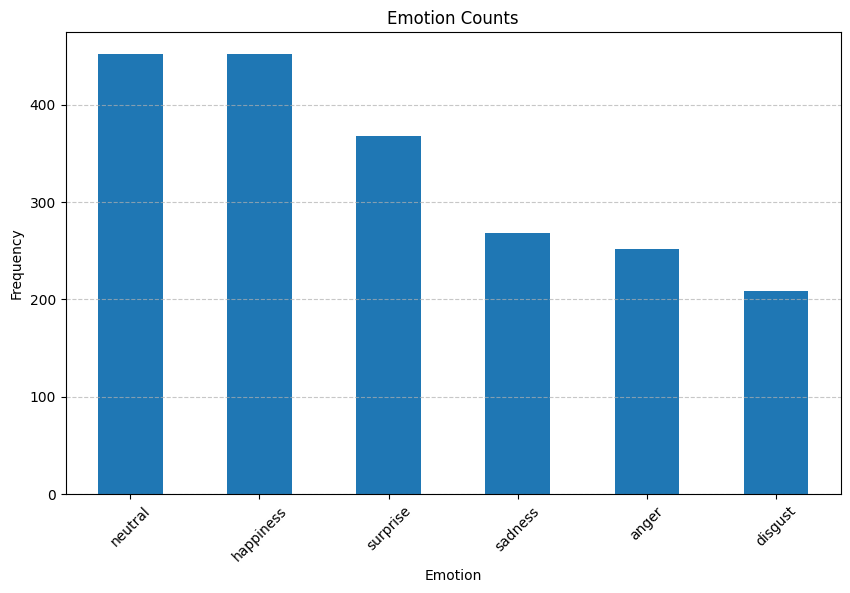

In [63]:
df = pd.read_csv('modified\sample_2000.csv')

emotion_counts = df['emotion'].value_counts()

print(emotion_counts)

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar')
plt.title('Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## 2. Train the model

In [64]:
# Path
csv_file = 'modified/1over6_original.csv' 
image_dir = 'images/'         

#Read
data = pd.read_csv(csv_file, header=None, names=['user_id', 'image', 'emotion'])

image_size = (224, 224) 
images = []
labels = []
for _, row in data.iterrows():
    image_path = os.path.join(image_dir, row['image'])
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        img = cv2.resize(img, image_size) / 255.0  
        images.append(img)
        labels.append(row['emotion'])

#convert to numpy arrays
images = np.array(images)
labels = pd.get_dummies(labels).values 

# Visualize the data:

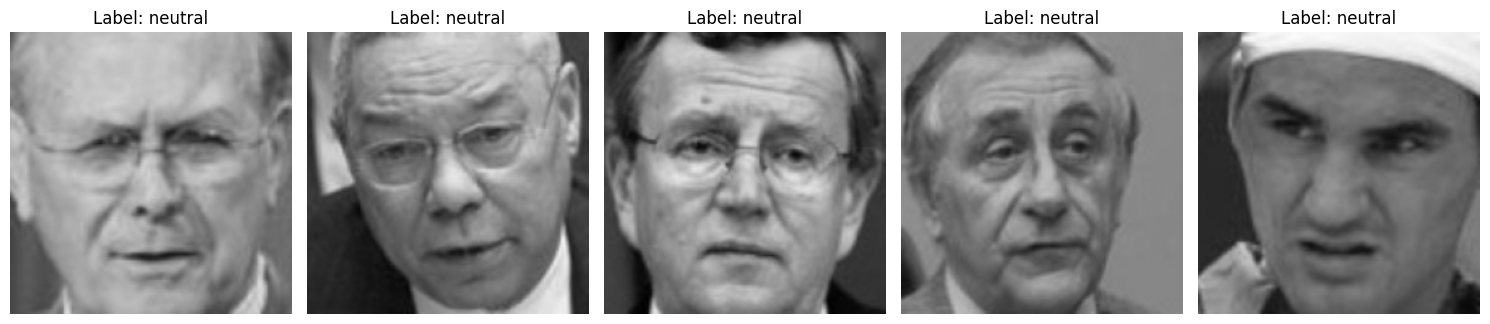

In [65]:
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Label: {data['emotion'][i+1]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

# Prepare the dataset, utilizes data augmentation

In [66]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [67]:
np.unique(y_train)


array([False,  True])

In [68]:
integer_labels = np.argmax(labels, axis=1)

#manually adjusting weight based on previous performance
class_weights_dict = {0: 9.03, 1: 10.94, 2: 0.39, 3: 0.33, 4: 8.49, 5: 6.19}
print("Class Weights:", class_weights_dict)

In [79]:
model = models.Sequential([
    layers.Conv2D(32, (7, 7), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),  
    layers.Dense(labels.shape[1], activation='softmax')  
])

optimizer = Adam(learning_rate=0.0001)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=20, validation_split=0.1, batch_size=16, class_weight=class_weights_dict)


Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 14s 235ms/step - accuracy: 0.4823 - loss: 0.5275 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.4976 - loss: 0.5024 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 230ms/step - accuracy: 0.4832 - loss: 0.5168 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.5067 - loss: 0.4933 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 225ms/step - accuracy: 0.5260 - loss: 0.4740 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 226ms/step - accuracy: 0.5029 - loss: 0.4971 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.5000 - loss: 0.5000 - val_accuracy: 0.5209 - val_loss: 0.4791
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 13s 224ms/step - accuracy: 0.4934 - loss: 0.5066 - val_accu

# Visulize the performance

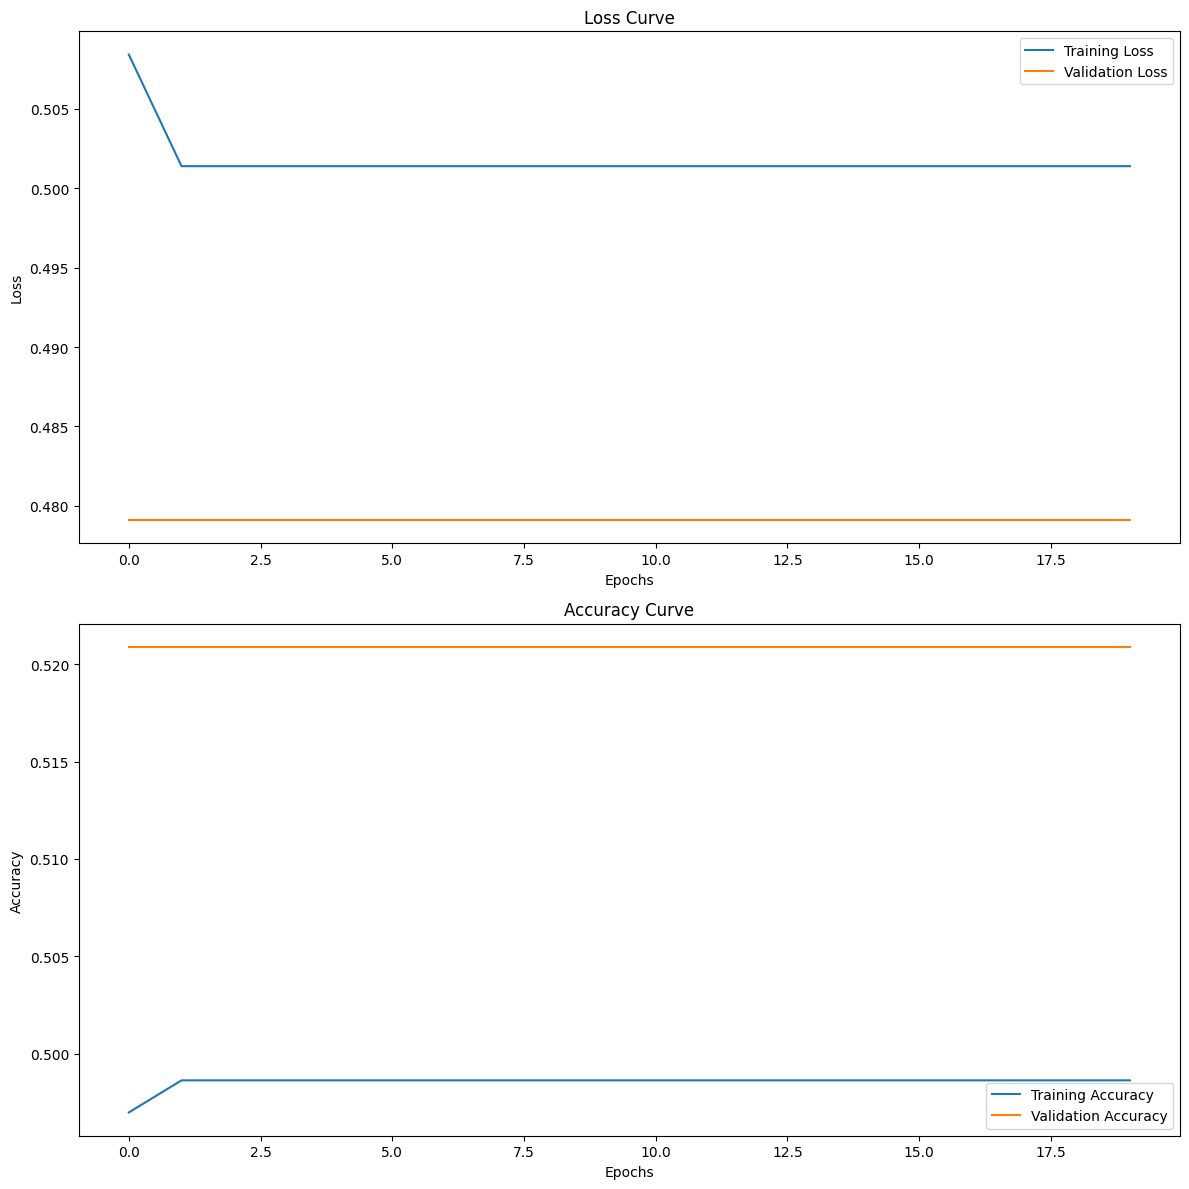

In [78]:
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


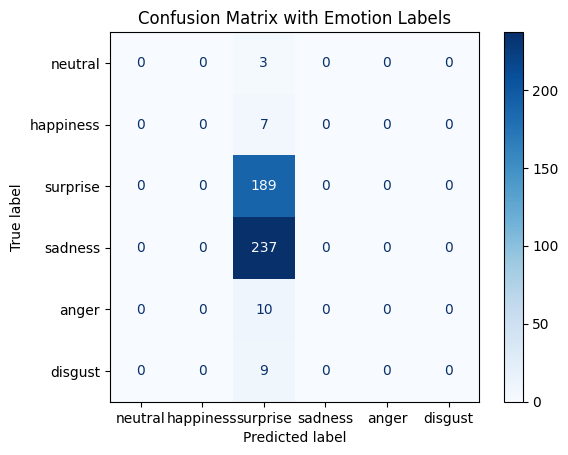

In [75]:
y_pred = model.predict(X_test)
emotion_labels = data[1:]['emotion'].unique()

y_pred_classes = y_pred.argmax(axis=1)
y_true_classes = y_test.argmax(axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=emotion_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix with Emotion Labels')
plt.show()

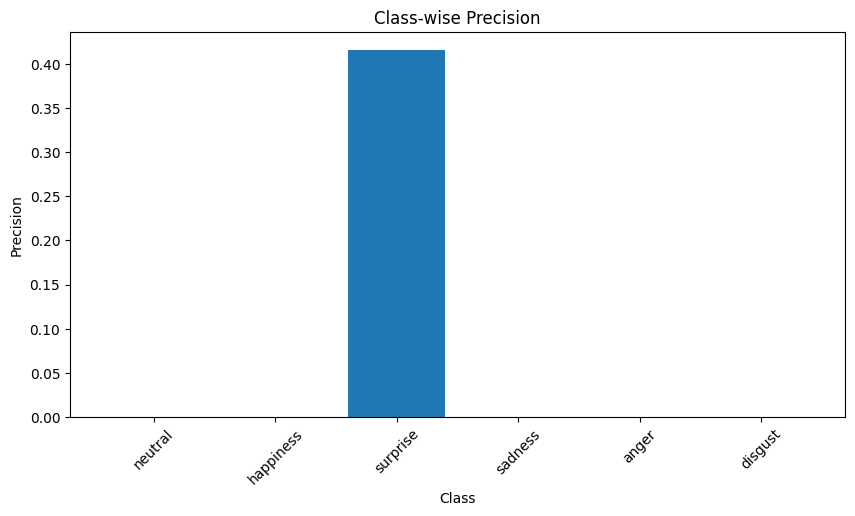

In [76]:
report = classification_report(y_true_classes, y_pred_classes, target_names=emotion_labels, output_dict=True, zero_division=0)
class_precisions = [report[label]['precision'] for label in emotion_labels if label in report]

# Plot class-wise precision
plt.figure(figsize=(10, 5))
plt.bar(emotion_labels, class_precisions)  # Use class labels for the x-axis
plt.title('Class-wise Precision')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.xticks(rotation=45)
plt.show()